In [1]:
import tensorflow as tf
import numpy as np
import os
print(tf.__version__)

2.0.0


In [2]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)   #[60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)   #[10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)  #[60000]
        self.test_label = self.test_label.astype(np.int32)   #[10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, np.shape(self.train_data)[0], size=batch_size)
        return self.train_data[index, :], self.train_label[index]

class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=200, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
        self.bn = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
  
    def call(self, inputs, training=None):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.bn(x, training=training)
        output = self.dense2(x)
        return output

num_epochs = 5
batch_size = 128
learning_rate = 0.001

def train():
    return model.fit(
         train_dataset,
         epochs=num_epochs,
         verbose=1,
         validation_data=test_dataset,
         callbacks=[cp_callback_mc]
         #callbacks=[cp_callback_mc, tensorboard_callback]
         )

def train_generator():
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #featurewise_center=True,  # 数据集去中心化
        rotation_range=20,        # 旋转角度范围
        width_shift_range=0.1,    # 水平位置平移
        height_shift_range=0.1   # 上下位置平移
        #horizontal_flip=True     # 随机水平翻转
        )    
    datagen.fit(data_loader.train_data)

    model.fit_generator(
         datagen.flow(data_loader.train_data, data_loader.train_label, batch_size=batch_size),
         steps_per_epoch=len(data_loader.train_data) / batch_size,
         epochs=num_epochs,
         verbose=1,
         validation_data=test_dataset,
         callbacks=[cp_callback_mc]
         )

def test():
    loss_and_metrics = model.evaluate(test_dataset)
    print(loss_and_metrics)

#def predict():
    #classes = model.predict(x_test, batch_size=128)

In [3]:
if __name__ == '__main__':
    checkpoint_path = "training_bn_sample_1/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model = MLP()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    
    data_loader = MNISTLoader()
    train_dataset = tf.data.Dataset.from_tensor_slices((data_loader.train_data, data_loader.train_label))
    train_dataset = train_dataset.shuffle(buffer_size=23000)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((data_loader.test_data, data_loader.test_label))
    test_dataset = test_dataset.shuffle(buffer_size=23000)
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    cp_callback_mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=0)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if(latest != None):
        model.load_weights(latest) 

    #log_dir = "./tensorboard"
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
    history = train()

Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1882 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.1990 - val_sparse_categorical_accuracy: 0.9654
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1918 - val_sparse_categorical_accuracy: 0.9649
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1869 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.2606 - val_sparse_categorical_accuracy: 0.9437
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9587


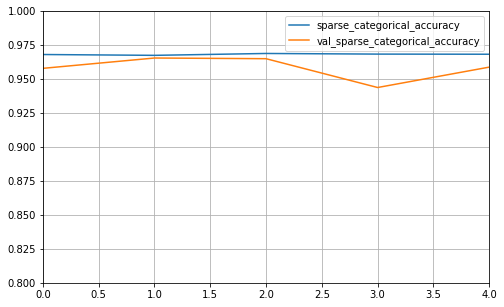

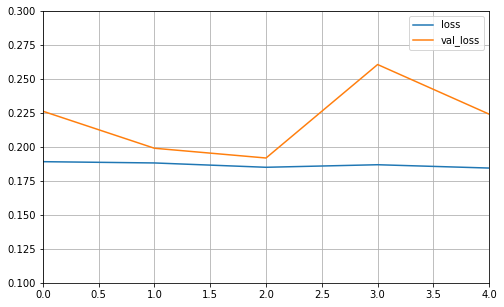

In [10]:
from custom_api import img_show
%matplotlib inline

img_show.plot_learning_curves_acc(history,0.8,1)
img_show.plot_learning_curves_loss(history,0.1,0.3)

In [19]:
    model.summary()

Model: "mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  157000    
_________________________________________________________________
batch_normalization (BatchNo multiple                  800       
_________________________________________________________________
dense_1 (Dense)              multiple                  2010      
Total params: 159,810
Trainable params: 159,410
Non-trainable params: 400
_________________________________________________________________


In [12]:
    test()

79/79 [==============================] - 0s 2ms/step - loss: 0.2460 - sparse_categorical_accuracy: 0.9641
[0.24599757715116574, 0.9641]


In [24]:
    train_generator()

Epoch 1/50
469/468 [==============================] - 19s 40ms/step - loss: 0.3965 - sparse_categorical_accuracy: 0.9142 - val_loss: 0.2730 - val_sparse_categorical_accuracy: 0.9499
Epoch 2/50
469/468 [==============================] - 19s 40ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.2580 - val_sparse_categorical_accuracy: 0.9506
Epoch 3/50
469/468 [==============================] - 20s 42ms/step - loss: 0.3985 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.2928 - val_sparse_categorical_accuracy: 0.9455
Epoch 4/50
469/468 [==============================] - 19s 41ms/step - loss: 0.3959 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.2893 - val_sparse_categorical_accuracy: 0.9416
Epoch 5/50
469/468 [==============================] - 19s 40ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.2370 - val_sparse_categorical_accuracy: 0.9625
Epoch 6/50
469/468 [==============================] - 19s 40ms/step - loss: 0.3912 - spars

Epoch 46/50
469/468 [==============================] - 19s 40ms/step - loss: 0.3918 - sparse_categorical_accuracy: 0.9138 - val_loss: 0.2564 - val_sparse_categorical_accuracy: 0.9561
Epoch 47/50
469/468 [==============================] - 18s 39ms/step - loss: 0.3943 - sparse_categorical_accuracy: 0.9128 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9502
Epoch 48/50
469/468 [==============================] - 18s 39ms/step - loss: 0.3930 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.9462
Epoch 49/50
469/468 [==============================] - 20s 43ms/step - loss: 0.3920 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.9391
Epoch 50/50
469/468 [==============================] - 20s 43ms/step - loss: 0.3893 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.9469


(2, 2)
